# Exploring the Dynamics of Film Industry for Informed Decision-Making

In [80]:
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data Cleaning

### Movies

In [81]:
movies = pd.read_csv('tmdb_5000_movies.csv')
movies.head(2)

# 4803 rows × 20 columns

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [82]:
movies = movies.drop(['homepage', 'keywords', 'id', 'overview', 'spoken_languages', 'status', 'tagline','original_title'], axis=1, errors='ignore')
movies.head(2)

#4803 rows × 12 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500


In [83]:
def extract_data(json_str, key):
    """
    Extracts data from a JSON string based on the provided key.
    
    Args:
    - json_str (str): The JSON formatted string.
    - key (str): The key to extract data from.

    Returns:
    - str: A comma-separated string of extracted values.
    """
    try:
        data_list = json.loads(json_str)
    except json.JSONDecodeError:
        return json_str  # or return an empty string: return ''
    
    extracted_values = [item[key] for item in data_list]
    return ", ".join(extracted_values)

# Applying the function to various columns
movies['genres'] = movies['genres'].apply(lambda x: extract_data(x, 'name'))
movies['production_companies'] = movies['production_companies'].apply(lambda x: extract_data(x, 'name'))
movies['production_countries'] = movies['production_countries'].apply(lambda x: extract_data(x, 'name'))

movies.head(2)

#4803 rows × 12 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500


In [84]:
# Check if title is garbled, and Drop the garbled rows

def is_garbled(title):
    
    ''' The following regex checks for titles containing characters outside the 
        typical alphanumeric, space, and common punctuation range.'''
    
    return not bool(re.match(r'^[a-zA-Z0-9\s\.,;:\'\"!?()-]*$', title))


garbled_indices = movies[movies['title'].apply(is_garbled)].index
movies.drop(garbled_indices, inplace=True)

movies.head(2)

# 4705 rows × 12 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500


In [85]:
# Check if production_companies has garbled characters, and Drop them.

def filter_garbled_names(names_str):
    
    names = [name.strip() for name in names_str.split(',')]
    
    # use a regular expression to check for non-ASCII characters
    legitimate_names = [name for name in names if not re.search(r'[^\x00-\x7F]', name)]
    
    return ', '.join(legitimate_names)


movies['production_companies'] = movies['production_companies'].apply(filter_garbled_names)


In [86]:
movies.head()

# 4705 rows × 12 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"Action, Adventure, Crime",en,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",2015-10-26,880674609,148.0,Spectre,6.3,4466
3,250000000,"Action, Crime, Drama, Thriller",en,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,The Dark Knight Rises,7.6,9106
4,260000000,"Action, Adventure, Science Fiction",en,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,John Carter,6.1,2124


### Credits

In [87]:
credits = pd.read_csv('tmdb_5000_credits.csv')
credits.head(2)

# 4803 rows × 4 columns

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [88]:
credits = credits.drop(['crew', 'movie_id'], axis=1)

In [89]:
# get first 10 actors from each movie

def extract_actors(cast_str):
    # Check if the string is a valid JSON
    try:
        cast_list = json.loads(cast_str)
    except json.JSONDecodeError:
        return cast_str  # or return an empty string: return ''
    
    names = [actor['name'] for actor in cast_list][:10] #first 10
    return ", ".join(names)

# Apply the function and correct garbled characters
credits['cast'] = credits['cast'].apply(extract_actors)
credits['cast'] = credits['cast'].str.replace(r"\u00e5", "g")

credits.head()

# 4803 rows × 2 columns

/var/folders/j2/d6gfnc_j1w92nhthf02vfpy00000gn/T/ipykernel_82675/780571461.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  credits['cast'] = credits['cast'].str.replace(r"\u00e5", "g")


,title,cast
0,Avatar,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,Pirates of the Caribbean: At World's End,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,Spectre,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,The Dark Knight Rises,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,John Carter,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


In [90]:
# Check if title is garbled, and then Drop the garbled rows

def is_garbled(title):
    
    ''' The following regex checks for titles containing characters outside the 
        typical alphanumeric, space, and common punctuation range.'''
    
    return not bool(re.match(r'^[a-zA-Z0-9\s\.,;:\'\"!?()-]*$', title))


garbled_indices = credits[credits['title'].apply(is_garbled)].index
credits.drop(garbled_indices, inplace=True)

#credits.head()

# 4705 rows × 12 columns

In [91]:
# Check if cast has garbled characters, and then Drop them.

def filter_garbled_cast(names_str):
    
    names = [name.strip() for name in names_str.split(',')]
    
    # use a regular expression to check for non-ASCII characters
    legitimate_names = [name for name in names if not re.search(r'[^\x00-\x7F]', name)]
    
    return ', '.join(legitimate_names)


credits['cast'] = credits['cast'].apply(filter_garbled_cast)


In [92]:
credits.head()

# 4705 rows × 2 columns

,title,cast
0,Avatar,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,Pirates of the Caribbean: At World's End,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,Spectre,"Daniel Craig, Christoph Waltz, Ralph Fiennes, ..."
3,The Dark Knight Rises,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,John Carter,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


### Combine Datasets

In [93]:
df = pd.concat([movies, credits.drop(columns='title')], axis=1)
df.head(2)

#4705 rows × 13 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."


In [94]:
# Replace empty strings or white spaces with NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Drop rows containing NaN values
df.dropna(inplace=True)

df.head(2)

# 4335 rows × 13 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."


In [95]:
# Drop rows where 'budget' or 'revenue' is 0
df = df[(df['budget'] != 0) & (df['revenue'] != 0)]
df#.head(2)

# 3166 rows × 13 columns

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",en,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",2015-10-26,880674609,148.0,Spectre,6.3,4466,"Daniel Craig, Christoph Waltz, Ralph Fiennes, ..."
3,250000000,"Action, Crime, Drama, Thriller",en,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,The Dark Knight Rises,7.6,9106,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",en,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,John Carter,6.1,2124,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773,27000,Comedy,en,19.748658,"Miramax Films, View Askew Productions",United States of America,1994-09-13,3151130,92.0,Clerks,7.4,755,"Brian O'Halloran, Jeff Anderson, Jason Mewes, ..."
4788,12000,"Horror, Comedy, Crime",en,4.553644,Dreamland Productions,United States of America,1972-03-12,6000000,93.0,Pink Flamingos,6.2,110,"Divine, David Lochary, Mary Vivian Pearce, Min..."
4792,20000,"Crime, Horror, Mystery, Thriller",ja,0.212443,Daiei Studios,Japan,1997-11-06,99000,111.0,Cure,7.4,63,"Koji Yakusho, Masato Hagiwara, Tsuyoshi Ujiki,..."
4796,7000,"Science Fiction, Drama, Thriller",en,23.307949,Thinkfilm,United States of America,2004-10-08,424760,77.0,Primer,6.9,658,"Shane Carruth, David Sullivan, Casey Gooden, A..."


In [97]:
# Save as a csv file
df.to_csv('Movies_new_jieping.csv', index=False)

## EDA

In [55]:
df.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,3.122000e+03,3122.000000,3.122000e+03,3122.000000,3122.000000,3122.000000
mean,4.119975e+07,29.459504,1.233153e+08,110.980461,6.314382,993.193145
std,4.458499e+07,36.547987,1.882022e+08,21.041359,0.868798,1426.210889
min,1.000000e+00,0.037073,5.000000e+00,41.000000,0.000000,0.000000
25%,1.100000e+07,10.792509,1.760656e+07,97.000000,5.800000,189.000000
50%,2.600000e+07,20.698384,5.711211e+07,107.000000,6.300000,482.500000
75%,5.500000e+07,37.693989,1.490390e+08,121.000000,6.900000,1155.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,8.500000,13752.000000


In [56]:
df.head()

,budget,genres,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,Avatar,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",en,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",2015-10-26,880674609,148.0,Spectre,6.3,4466,"Daniel Craig, Christoph Waltz, Ralph Fiennes, ..."
3,250000000,"Action, Crime, Drama, Thriller",en,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,The Dark Knight Rises,7.6,9106,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",en,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,John Carter,6.1,2124,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."


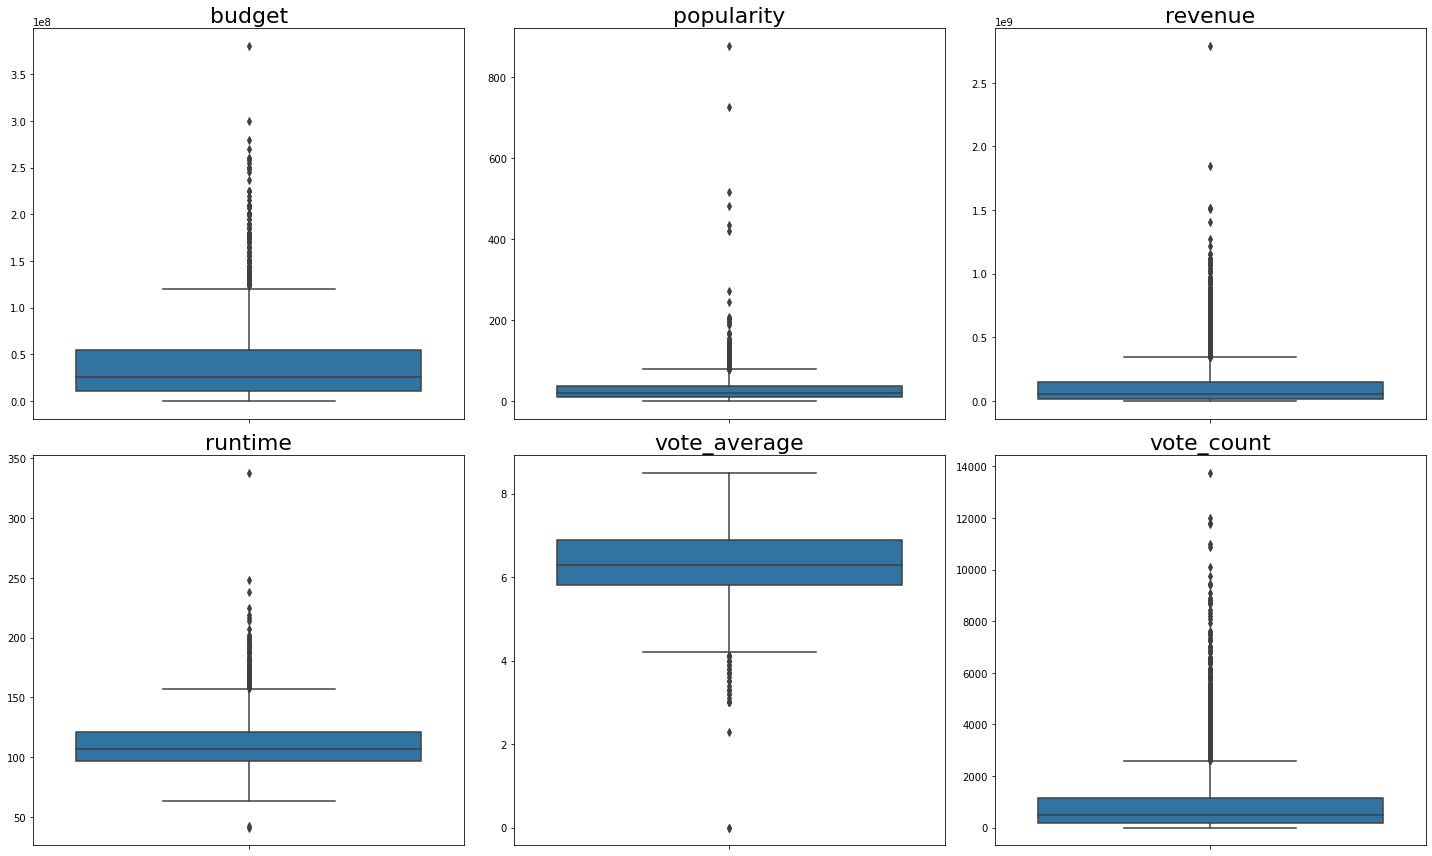

In [57]:
# List of numerical columns
numerical_columns = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Plot boxplots for numerical columns
plt.figure(figsize=(20, 12))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col, fontsize=22)
    plt.ylabel('')

plt.tight_layout()
plt.show()

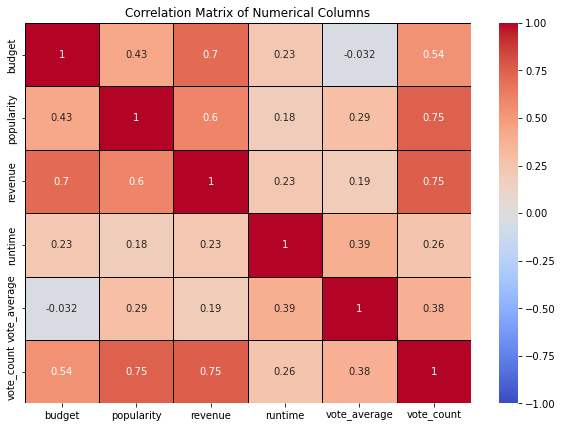

In [58]:
# Compute the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

strong positive correlation:

1. budget vs. revenue = means that movies with higher budgets tend to have higher box office revenue.

2. vote_count vs. revenue = movies with more votes/watches will get higher box office.

3. popularity vs. vote_count = popular movies also generally have more ratings.

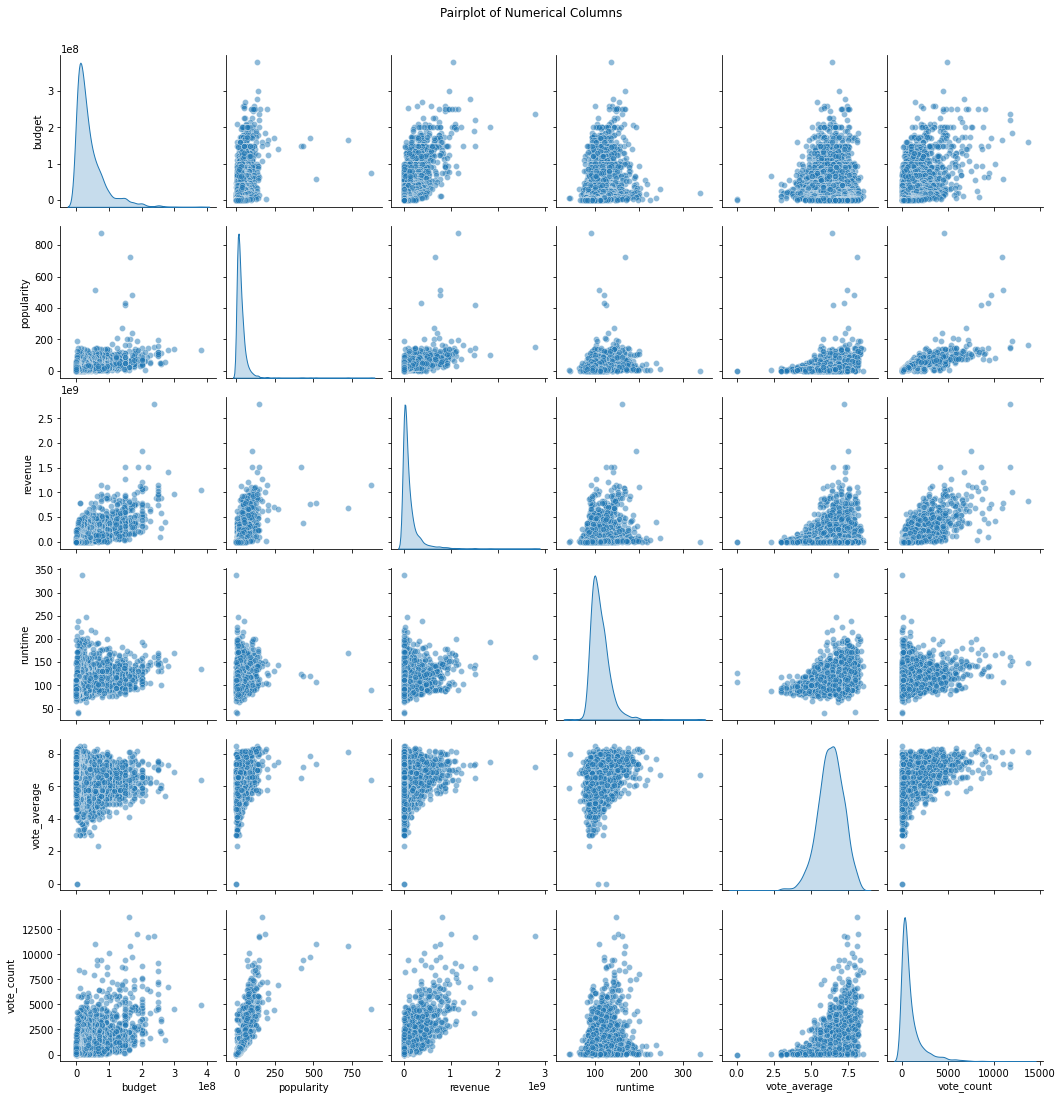

In [59]:
# Plot the pairplot for numerical columns to see relationships between them
sns.pairplot(df[numerical_columns], diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Pairplot of Numerical Columns", y=1.02)
plt.show()

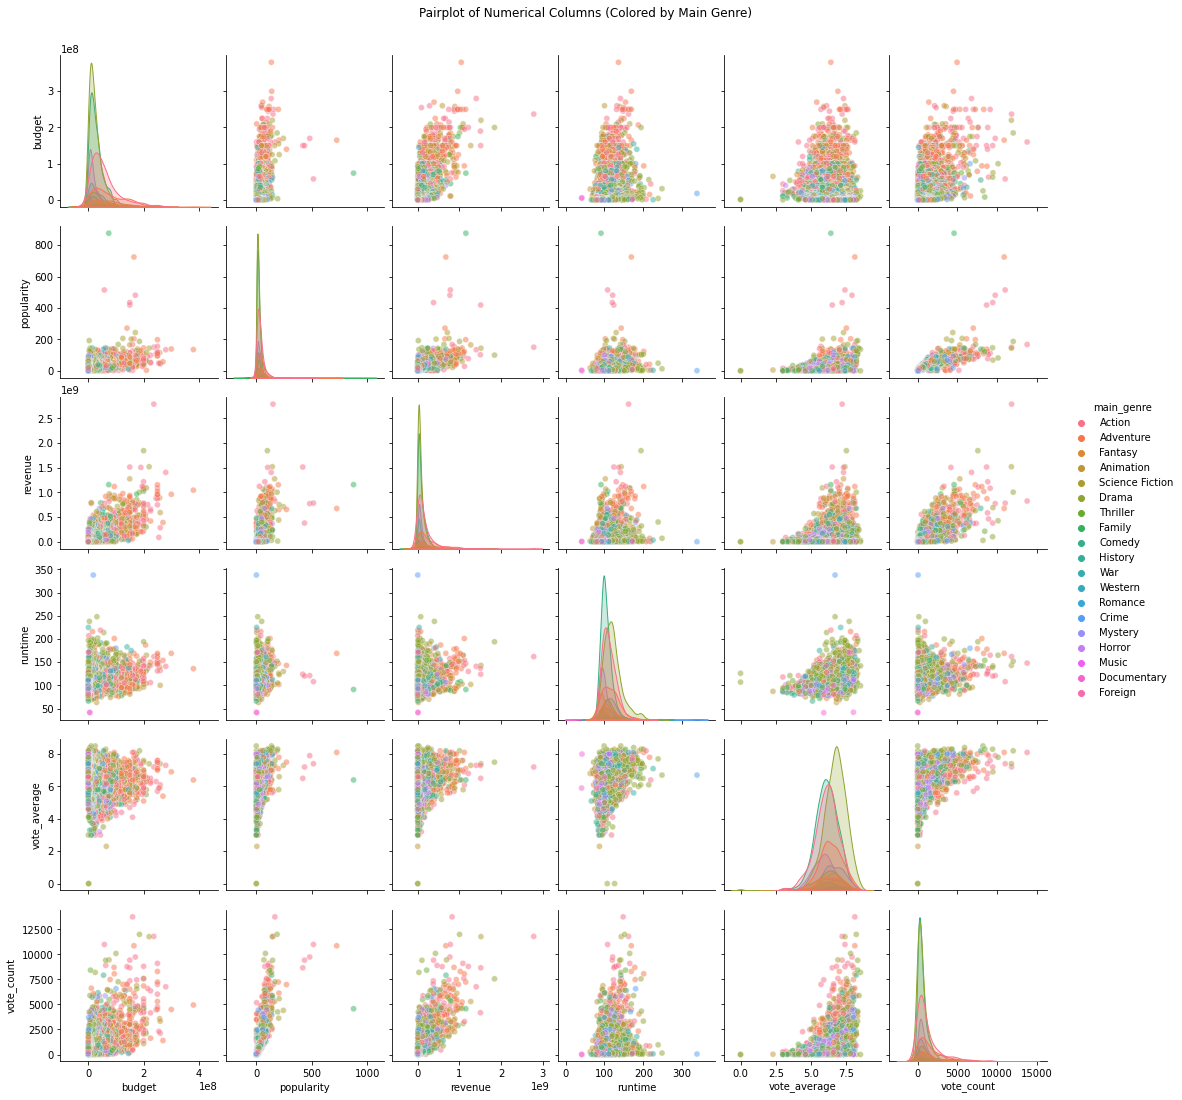

In [60]:
# Find the most common genre for each movie
df['main_genre'] = df['genres'].str.split(", ").apply(lambda x: x[0] if isinstance(x, list) and x else None)

# Plot the pairplot with colors representing the main genre
sns.pairplot(df[numerical_columns + ['main_genre']], hue='main_genre', diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Pairplot of Numerical Columns (Colored by Main Genre)", y=1.02)
plt.show()

positive correlation

1. Budget vs. revenue
2. vote_count vs. revenue
3. popularity vs. vote_count